# Korean2English Neural Machine Translation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf

from time import time
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font', family="NanumBarunGothic") 

## 1. Data Preprocessing

In [3]:
import unicodedata
import re

from konlpy.tag import Kkma
kkma = Kkma()

In [4]:
with open('data/raw/crawl_dict_ko.txt', 'r') as f_ko, open('data/raw/crawl_dict_en.txt', 'r') as f_en :
    ss_ko = [x[:-1] for x in f_ko.readlines()]
    ss_en = [x[:-1] for x in f_en.readlines()]

### a) Cleaning Data

In [136]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.strip())
    s = re.sub(r"([\",.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z\",.!?]+", r" ", s)
    return s.strip()

def normalize_string_ko(s):
    return ' '.join(kkma.morphs(s))

#### remove dirty data

In [12]:
remove_candidate = []
for i, s_ko in enumerate(ss_ko):
    if len(re.findall(r"[^ ,\"가-힣.!?]+", s_ko)) > 0:
        remove_candidate.append(i)

for i, s_en in enumerate(ss_en):
    if len(re.findall(r"[^ ,\"a-zA-Z.!?]+", s_en)) > 0:
        remove_candidate.append(i)

remove_candidate = np.sort(np.unique(remove_candidate))[::-1]
for i in tqdm(remove_candidate):
    del ss_ko[i]
    del ss_en[i]

100%|██████████| 421319/421319 [02:15<00:00, 3119.48it/s] 


In [3]:
# save clean data
#with open('data/raw/dict.ko.total', 'w') as f_ko, open('data/raw/dict.en.total', 'w') as f_en :
#    for i in range(len(ss_ko)):
#        f_ko.write(ss_ko[i] + '\n')
#        f_en.write(ss_en[i] + '\n')

#### normalize data

In [137]:
norm_en = []
words_en = []
for s_en in tqdm(ss_en):
    norm = normalize_string(s_en)
    norm_en.append(norm)
    words_en.extend(norm.split())
    
words_en = np.unique(words_en)
words_en = np.insert(words_en, [0, 0, 0], ['<unk>', '<s>', '</s>'])

100%|██████████| 808453/808453 [00:14<00:00, 55265.90it/s]


In [ ]:
norm_ko = []
words_ko = []
for s_ko in tqdm(ss_ko):
    norm = normalize_string_ko(s_ko)
    norm_ko.append(norm)
    words_ko.extend(norm.split())
    
words_ko = np.unique(words_ko)
words_ko = np.insert(words_ko, [0, 0, 0], ['<unk>', '<s>', '</s>'])

In [4]:
# save normalized data
#with open('data/raw/vocab.en', 'w') as f:
#    for word in words_en:
#        f.write(word + '\n')
#
#with open('data/raw/vocab.ko', 'w') as f:
#    for word in words_ko:
#        f.write(word + '\n')
#
#with open('data/raw/dict.ko.norm', 'w') as f_ko, open('data/raw/dict.en.norm', 'w') as f_en:
#    for i in range(len(norm_en)):
#        f_ko.write(norm_ko[i] + '\n')
#        f_en.write(norm_en[i] + '\n')

In [37]:
# split_data for training
#rand_ids = np.random.permutation(np.arange(len(norm_ko)))
#
#rand_ko = norm_ko[rand_ids]
#rand_en = norm_en[rand_ids]
#
# len(norm_ko) = 808453 = 788453 + 10000 + 10000
#with open('data/raw/dict.ko.train', 'w') as f_ko, open('data/raw/dict.en.train', 'w') as f_en:
#    for i in range(788453):
#        f_ko.write(rand_ko[i] + '\n')
#        f_en.write(rand_en[i] + '\n')
#        
#with open('data/raw/dict.ko.valid', 'w') as f_ko, open('data/raw/dict.en.valid', 'w') as f_en:
#    for i in range(788453, 788453+10000):
#        f_ko.write(rand_ko[i] + '\n')
#        f_en.write(rand_en[i] + '\n')
#        
#with open('data/raw/dict.ko.test', 'w') as f_ko, open('data/raw/dict.en.test', 'w') as f_en:
#    for i in range(788453+10000, 788453+10000+10000):
#        f_ko.write(rand_ko[i] + '\n')
#        f_en.write(rand_en[i] + '\n')

### b) Data Pipelining

#### convert words to indices

In [3]:
UNK_token = 0
SOS_token = 1
EOS_token = 2

In [4]:
with open('./data/raw/vocab.ko', 'r') as f, open('./data/raw/vocab.en', 'r') as g:
    src_vocab = [x[:-1] for x in f.readlines()]
    tgt_vocab = [x[:-1] for x in g.readlines()]
    
def list_to_dict(vocab_list):
    ret = {}
    for i in range(len(vocab_list)):
        ret[i] = vocab_list[i]
    
    return ret

src_vocab, tgt_vocab = list_to_dict(src_vocab), list_to_dict(tgt_vocab)
src_vocab_inv, tgt_vocab_inv = {v: k for k, v in src_vocab.items()}, {v: k for k, v in tgt_vocab.items()}


def word2idx(vocab_inv, word):
    try:
        ret = vocab_inv[word]
    except:
        ret = UNK_token
    return ret

def idx2word(vocab, idx):
    return vocab[idx]

In [5]:
with open('./data/raw/dict.ko.train', 'r') as f:
    sources = [[word2idx(src_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
    
sources = np.array(sources)

with open('./data/raw/dict.en.train', 'r') as f:
    targets = [[word2idx(tgt_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]

targets = np.array(targets)

#### make batch

In [6]:
batch_size = 128
max_time = 50
time_major = True

In [7]:
class Dummy(object):
    pass


def batch_iter(batch_size, sources, targets, ending=False):
    """
        Generates a batch iterator for the dataset.
    """

    data_size = len(sources)

    rand_inds = np.random.permutation(np.arange(data_size))

    num_batches = int(data_size / batch_size)

    if data_size % batch_size > 0:
        num_batches = int(data_size / batch_size) + 1

    batch_num = 0
    end_flag = False
    while True:
        start_index = batch_num * batch_size
        end_index = (batch_num + 1) * batch_size
        
        if end_index > data_size:
            if ending:
                end_flag = True
            else: 
                print('rebatching...')
                batch_num = 0
                rand_inds = np.random.permutation(rand_inds)
                start_index = 0
                end_index = batch_size
        
        
        srcs = sources[rand_inds[start_index:end_index]]
        tgts = targets[rand_inds[start_index:end_index]]
        source_sequence_lengths = np.array([np.min([len(x)+1, max_time]) for x in srcs])
        target_sequence_lengths = np.array([np.min([len(x)+1, max_time]) for x in tgts])
        
        srcs = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in srcs])
        tgts = np.array([x[:max_time-1] + [EOS_token] + [0]*(max_time-len(x)-1) for x in tgts])
        
        srcs = srcs.T
        tgts = tgts.T
        
        params = Dummy()
        params.source_sequence_lengths = source_sequence_lengths
        params.target_sequence_lengths = target_sequence_lengths
        params.sources = srcs
        params.targets = tgts
        
        yield params
        
        if end_flag:
            return
        
        batch_num += 1

In [8]:
batch = batch_iter(batch_size, sources, targets)

## 2. Model

In [9]:
from tensorflow.python.layers import core as layers_core

In [10]:
# # Building the models

# ## The Embedding

# In[9]:

src_vocab_size = len(src_vocab)
tgt_vocab_size = len(tgt_vocab)
embedding_size = 256
num_units = embedding_size

In [11]:
def initialization():
    model = Dummy()
    model.encoder_inputs = tf.placeholder('int32', [max_time, None], name='encoder_inputs')
    model.targets = tf.placeholder('int32', [max_time, None], name='target')
    model.decoder_inputs = tf.concat([tf.fill([1, tf.shape(model.targets)[1]], SOS_token), model.targets[:-1,:]], 0)
    
    model.source_sequence_lengths = tf.placeholder('int32', [None], name='source_sequence_lengths')
    model.target_sequence_lengths = tf.placeholder('int32', [None], name='target_sequence_lengths')
    
    model.dropout = tf.placeholder('float32', [], name='dropout')
    model.learning_rate = tf.placeholder('float32', [], name='learning_rate')
    model.max_gradient_norm = tf.placeholder('float32', [], name='max_gradient_norm') # often set to a value like 5 or 1

    
    return model

In [12]:
def embedding(model):
    with tf.variable_scope("embedding", dtype='float32') as scope:
        # Embedding
        embedding_encoder = tf.get_variable("embedding_encoder", [src_vocab_size, embedding_size])
        embedding_decoder = tf.get_variable("embedding_decoder", [tgt_vocab_size, embedding_size])
        # Look up embedding:
        #   encoder_inputs: [max_time, batch_size]
        #   encoder_emp_inp: [max_time, batch_size, embedding_size]
        encoder_emb_inp = tf.nn.embedding_lookup(embedding_encoder, model.encoder_inputs)
        decoder_emb_inp = tf.nn.embedding_lookup(embedding_decoder, model.decoder_inputs)
        
        model.embedding_encoder = embedding_encoder
        model.embedding_decoder = embedding_decoder
        model.encoder_emb_inp = encoder_emb_inp
        model.decoder_emb_inp = decoder_emb_inp
        
    return model

In [13]:
# ## The Encoder
def encoder(model):
    with tf.variable_scope("encoder", dtype='float32') as scope:
        # Build RNN cell
        # Construct forward and backward cells
        forward_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
        forward_cell = tf.contrib.rnn.DropoutWrapper(cell=forward_cell, input_keep_prob=(1.0 - model.dropout))
        backward_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
        backward_cell = tf.contrib.rnn.DropoutWrapper(cell=backward_cell, input_keep_prob=(1.0 - model.dropout))

        bi_outputs, bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(
            forward_cell, backward_cell, model.encoder_emb_inp, dtype='float32',
            sequence_length=model.source_sequence_lengths, time_major=True)
        bi_encoder_outputs = tf.concat(bi_outputs, -1)
        
        encoder_outputs = bi_encoder_outputs
        encoder_state = bi_encoder_state
        """
        # Stacking encoders
        encoder_cell = tf.contrib.rnn.BasicLSTMCell(num_units)

        # Run Dynamic RNN
        #   encoder_outpus: [max_time, batch_size, num_units]
        #   encoder_state: [batch_size, num_units]
        encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
            encoder_cell, bi_encoder_outputs, dtype='float32',
            sequence_length=model.source_sequence_lengths, time_major=True)
        """        
        model.encoder_outputs = encoder_outputs
        model.encoder_state = encoder_state
        
    return model

In [14]:
# ## Decoder
def decoder(model):
    with tf.variable_scope("decoder", dtype='float32') as scope:
        """ Attention Mechanisms """
        # attention_states: [batch_size, max_time, num_units]
        attention_states = tf.transpose(model.encoder_outputs, [1, 0, 2])

        # Create an attention mechanism
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(
            num_units, attention_states, scale=True,
            memory_sequence_length=model.source_sequence_lengths)

        # Build RNN cell
        cell_list = []
        for i in range(2):
            cell = tf.contrib.rnn.BasicLSTMCell(num_units)
            cell = tf.contrib.rnn.DropoutWrapper(cell=cell, input_keep_prob=(1.0 - model.dropout))
            cell_list.append(cell)
        
        decoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)

        decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
            decoder_cell, attention_mechanism,
            alignment_history=True,
            attention_layer_size=num_units, name="attention")

        decoder_initial_state = decoder_cell.zero_state(tf.shape(model.decoder_emb_inp)[1], 'float32').clone(cell_state=model.encoder_state)
        """"""
        # Helper
        helper = tf.contrib.seq2seq.TrainingHelper(
            model.decoder_emb_inp, model.target_sequence_lengths, time_major=True)
        # Decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, helper, decoder_initial_state)
        # Dynamic decoding
        outputs, final_context_state, _ = tf.contrib.seq2seq.dynamic_decode(
            decoder,
            output_time_major=True,
            swap_memory=True,
            scope=scope)

        #projection
        output_layer = layers_core.Dense(tgt_vocab_size, use_bias=False, name="output_projection")
        logits = output_layer(outputs.rnn_output)
        
    model.logits = logits
    model.decoder_cell = decoder_cell
    model.decoder_initial_state = decoder_initial_state
    model.output_layer = output_layer
    model.final_context_state = final_context_state
    
    return model

In [15]:
# ## Loss & Gradient computation & optimization

def optimizer(model):
    curr_max_time = tf.shape(model.logits)[0]
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=model.targets[:curr_max_time,:], logits=model.logits)
    target_weights = tf.sequence_mask(model.target_sequence_lengths, curr_max_time, dtype=model.logits.dtype)

    # When time_major is True
    target_weights = tf.transpose(target_weights)

    loss = tf.reduce_sum(crossent * target_weights) / tf.to_float(tf.shape(model.decoder_emb_inp)[1])

    # Calculate and clip gradients
    parameters = tf.trainable_variables()
    gradients = tf.gradients(loss, parameters)
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, model.max_gradient_norm)

    # Optimization
    optimizer = tf.train.GradientDescentOptimizer(model.learning_rate)
    update_step = optimizer.apply_gradients(zip(clipped_gradients, parameters))
    
    model.loss = loss
    model.update_step = update_step
    
    return model

In [16]:
def create_model():
    model = initialization()
    model = embedding(model)
    model = encoder(model)
    model = decoder(model)
    
    return model

In [17]:
model = create_model()
model = optimizer(model)

In [18]:
# ## Running training

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [19]:
## Logging 

def create_attention_images(final_context_state):
    """create attention image"""
    attention_images = (final_context_state.alignment_history.stack())
    # Reshape to (batch, src_seq_len, tgt_seq_len,1)
    attention_images = tf.expand_dims(
        tf.transpose(attention_images, [1, 2, 0]), -1)
    # Scale to range [0, 255]
    attention_images *= 255
    return attention_images

def arr2stn(vocab, sentences):
    def foo_iter(stn):
        try:
            end_idx = stn.index(EOS_token)
        except:
            end_idx = len(stn)
        return ' '.join([idx2word(vocab, word) for word in stn[:end_idx]])
    
    
    
    if len(sentences.shape)==1:
        stn = sentences.tolist()
        ret = foo_iter(stn)        
    else:
        ret = []
        sentences = sentences.tolist()
        
        for stn in sentences:
            ret.append(foo_iter(stn))
    return ret

# logging
tf.summary.scalar('learning_rate', model.learning_rate)
tf.summary.scalar('cost', model.loss)
attention_images = create_attention_images(model.final_context_state)
tf.summary.image("attention_images", attention_images[:1, 
                                                      :model.source_sequence_lengths[0], 
                                                      :model.target_sequence_lengths[0]])
summaries = tf.summary.merge_all()

summary_writer = tf.summary.FileWriter('./logs')

In [20]:
for i in tqdm(range(0,20000)):
    
    if i==0:
        lr = 1.
    elif i==12000:
        lr = .5
    elif i==14000:
        lr = .25
    elif i==16000:
        lr = .125
    elif i==18000:
        lr = .0625
    
    params = next(batch)
    feed_dict={model.learning_rate: lr,
               model.dropout: .2,
               model.max_gradient_norm: 5,
               model.source_sequence_lengths: params.source_sequence_lengths,
               model.target_sequence_lengths: params.target_sequence_lengths,
               model.encoder_inputs: params.sources,
               model.targets: params.targets}

    _, s = sess.run([model.update_step, summaries], feed_dict=feed_dict)
    #_, s, t = sess.run([model.update_step, summaries, model.logits[:,0,:]], feed_dict=feed_dict)
    #text_summaries = tf.Summary()
    #text_summaries.value.add(tag='source', simple_value=arr2stn(src_vocab, params.sources.T[0]))
    #text_summaries.value.add(tag='target', simple_value=arr2stn(tgt_vocab, np.argmax(t,1)))
    #text_summaries.value.add(tag='truth', simple_value=arr2stn(tgt_vocab, params.targets.T[0]))
    summary_writer.add_summary(s, i)

 31%|███       | 6159/20000 [37:08<1:29:56,  2.56it/s]

rebatching...


 62%|██████▏   | 12318/20000 [1:14:18<44:19,  2.89it/s]  

rebatching...


 92%|█████████▏| 18477/20000 [1:51:30<08:34,  2.96it/s]  

rebatching...


100%|██████████| 20000/20000 [2:00:45<00:00,  2.89it/s]


saver = tf.train.Saver()
saver.save(sess, './log/model.ckpt')

## 3. Evaluation

In [22]:
from bleu import _bleu_online

In [65]:
# # Evaluating the network
def evaluation(model):
    # In[34]:

    model.maximum_iterations = tf.round(tf.reduce_max(model.source_sequence_lengths) * 2)


    # In[35]:

    with tf.variable_scope('decoder', reuse=True) as scope:
    # Dynamic decoding
        # Helper
        helper_eval = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            model.embedding_decoder, tf.fill([tf.shape(model.decoder_emb_inp)[1]], SOS_token),
            EOS_token)
        # Decoder
        decoder_eval = tf.contrib.seq2seq.BasicDecoder(
            model.decoder_cell, helper_eval, model.decoder_initial_state,
            output_layer=model.output_layer)

        outputs_eval, final_context_state_eval, _ = tf.contrib.seq2seq.dynamic_decode(
            decoder_eval, maximum_iterations=model.maximum_iterations,
            swap_memory=True, scope=scope)

        model.logits_eval = outputs_eval.rnn_output
        
    curr_max_time = tf.shape(model.logits)[0]
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=model.targets[:curr_max_time,:], logits=model.logits)
    target_weights = tf.sequence_mask(model.target_sequence_lengths, curr_max_time, dtype=model.logits.dtype)

    # When time_major is True
    target_weights = tf.transpose(target_weights)

    loss = tf.reduce_sum(crossent * target_weights) / tf.to_float(tf.shape(model.decoder_emb_inp)[1])
    
    model.loss_eval = loss
    return model

In [ ]:
model_eval = evaluation(model)

In [25]:
with open('./data/raw/dict.ko.valid', 'r') as f:
    sources_val = [[word2idx(src_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
sources_val = np.array(sources_val)

with open('./data/raw/dict.en.valid', 'r') as f:
    targets_val = [[word2idx(tgt_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
targets_val = np.array(targets_val)

In [26]:
batch_val = batch_iter(32, sources_val, targets_val, ending=True)
truths = []
preds = []
for params in tqdm(batch_val):
    feed_dict_test={model.dropout: 0.,
                    model.source_sequence_lengths: params.source_sequence_lengths,
                    model.target_sequence_lengths: params.target_sequence_lengths,
                    model.encoder_inputs: params.sources,
                    model.targets: params.targets}
    
    truths.extend(arr2stn(tgt_vocab, params.targets.T))
    preds.extend(arr2stn(tgt_vocab, np.argmax(sess.run(model.logits_eval, feed_dict_test),2)))
    
_bleu_online([truths], preds)

313it [01:14,  4.39it/s]


26.479544524543506

In [28]:
with open('./data/raw/dict.ko.test', 'r') as f:
    sources_tst = [[word2idx(src_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
sources_tst = np.array(sources_tst)

with open('./data/raw/dict.en.test', 'r') as f:
    targets_tst = [[word2idx(tgt_vocab_inv, word)for word in sentence[:-1].split(' ')] for sentence in f.readlines()]
targets_tst = np.array(targets_tst)

In [30]:
batch_val = batch_iter(32, sources_tst, targets_tst, ending=True)
truths = []
preds = []
for params in tqdm(batch_val):
    feed_dict_test={model.dropout: 0.,
                    model.source_sequence_lengths: params.source_sequence_lengths,
                    model.target_sequence_lengths: params.target_sequence_lengths,
                    model.encoder_inputs: params.sources,
                    model.targets: params.targets}
    
    truths.extend(arr2stn(tgt_vocab, params.targets.T))
    preds.extend(arr2stn(tgt_vocab, np.argmax(sess.run(model.logits_eval, feed_dict_test),2)))
    
_bleu_online([truths], preds)

26.244038578261836

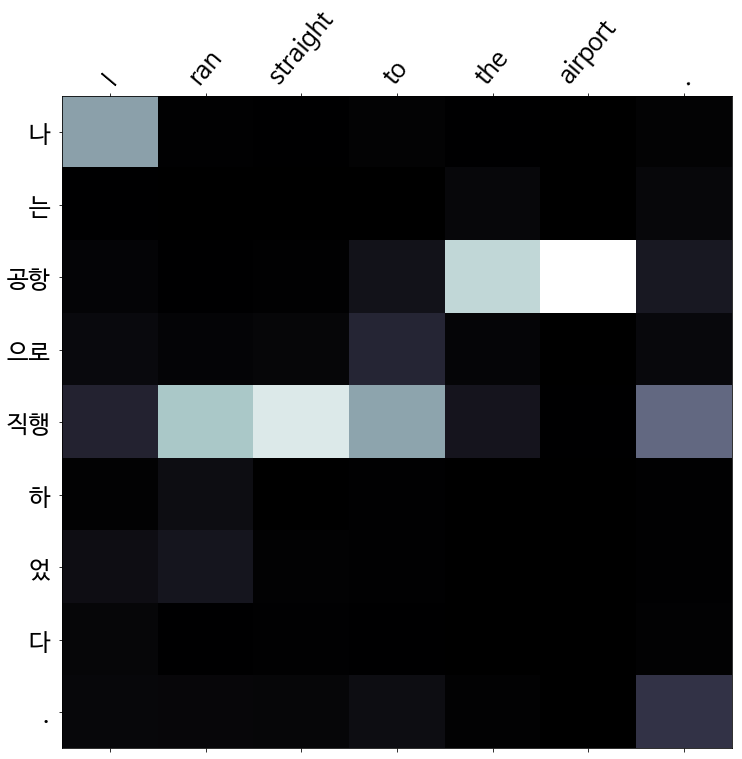

In [108]:
feed_dict={model.dropout: 0.,
               model.source_sequence_lengths: params.source_sequence_lengths,
               model.target_sequence_lengths: params.target_sequence_lengths,
               model.encoder_inputs: params.sources,
               model.targets: params.targets}


sampled_idx = -10
img, pred = sess.run([attention_images[sampled_idx], model.logits_eval[sampled_idx]], feed_dict)
src = arr2stn(src_vocab, params.sources.T[sampled_idx]).split()
pred = arr2stn(tgt_vocab, np.argmax(pred, 1)).split()
img = img[:len(src),:len(pred),0]

fig, ax = plt.subplots(figsize=(12,12))
ax.matshow(img, cmap='bone', aspect='auto')
ax.set_yticks(range(len(src)))
ax.set_xticks(range(len(pred)))
ax.set_yticklabels([x + ' ' for x in src], rotation=0, fontsize=24)
_ = ax.set_xticklabels(pred, rotation=50, fontsize=24)

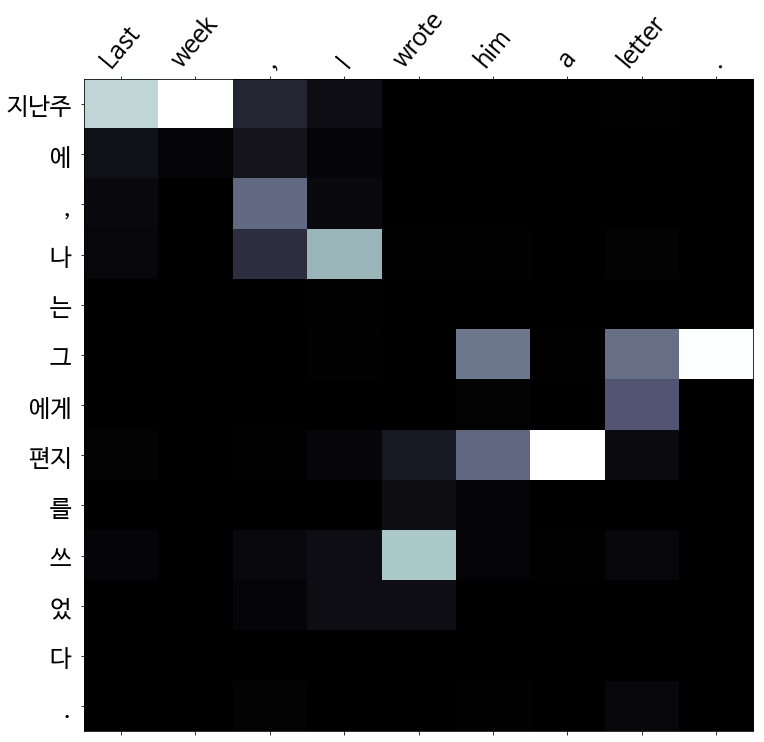

In [109]:
feed_dict={model.dropout: 0.,
               model.source_sequence_lengths: params.source_sequence_lengths,
               model.target_sequence_lengths: params.target_sequence_lengths,
               model.encoder_inputs: params.sources,
               model.targets: params.targets}


sampled_idx = -7
img, pred = sess.run([attention_images[sampled_idx], model.logits_eval[sampled_idx]], feed_dict)
src = arr2stn(src_vocab, params.sources.T[sampled_idx]).split()
pred = arr2stn(tgt_vocab, np.argmax(pred, 1)).split()
img = img[:len(src),:len(pred),0]

fig, ax = plt.subplots(figsize=(12,12))
ax.matshow(img, cmap='bone', aspect='auto')
ax.set_yticks(range(len(src)))
ax.set_xticks(range(len(pred)))
ax.set_yticklabels([x + ' ' for x in src], rotation=0, fontsize=24)
_ = ax.set_xticklabels(pred, rotation=50, fontsize=24)

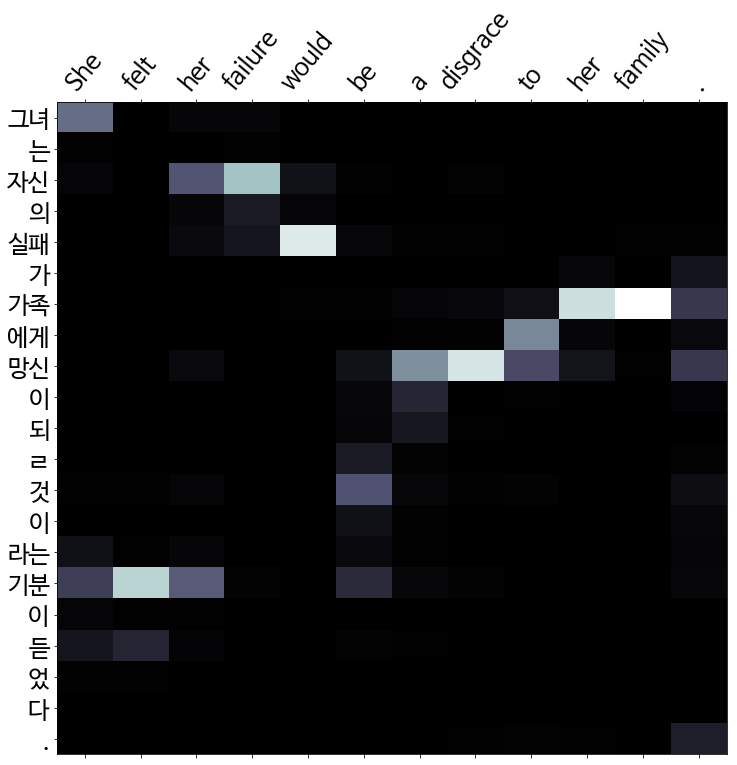

In [71]:
feed_dict={model.dropout: 0.,
               model.source_sequence_lengths: params.source_sequence_lengths,
               model.target_sequence_lengths: params.target_sequence_lengths,
               model.encoder_inputs: params.sources,
               model.targets: params.targets}


sampled_idx = 12
img, pred = sess.run([attention_images[sampled_idx], model.logits_eval[sampled_idx]], feed_dict)
src = arr2stn(src_vocab, params.sources.T[sampled_idx]).split()
pred = arr2stn(tgt_vocab, np.argmax(pred, 1)).split()
img = img[:len(src),:len(pred),0]

fig, ax = plt.subplots(figsize=(12,12))
ax.matshow(img, cmap='bone', aspect='auto')
ax.set_yticks(range(len(src)))
ax.set_xticks(range(len(pred)))
ax.set_yticklabels(src, rotation=0, fontsize=24)
_ = ax.set_xticklabels(pred, rotation=50, fontsize=24)